In [11]:
# Basic packagess
import pandas as pd
import numpy as np
from scipy import stats 
# Results visualization
import matplotlib.pyplot as plt
import seaborn as sns
# lifelines
from lifelines.datasets import load_waltons
from lifelines import CoxPHFitter,KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler

def confidence_interval(stats,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
    
all_predictors = [
    "original_firstorder_Energy",
    "original_shape_Compactness",
    "original_glrlm_GrayLevelNonUniformity",
    "wavelet-HLH_glrlm_GrayLevelNonUniformity",
    "original_shape_Volume"]

hugo_predictors = [
    "original_firstorder_Energy",
    "original_shape_Compactness",
    "original_glrlm_GrayLevelNonUniformity",
    "wavelet-HLH_glrlm_GrayLevelNonUniformity"]
hugo_volume = ["original_shape_Volume"]

hugo_outcome = ["Survival.time"]

df1_radiomics= pd.read_csv('./data/DLR_LUNG1_Radiomics.csv')
df1_clinical = pd.read_csv('./data/DLR_LUNG1_ClinicalUpdated.csv')
df1_merge = df1_radiomics.merge(df1_clinical,on = "patient_id")
df1_merge['original_shape_Sphericity'] = df1_merge['original_shape_Sphericity'] **3
df1_merge = df1_merge.rename(index=str,columns={'original_shape_Sphericity':'original_shape_Compactness'})
# dflung1 = df1_merge[hugo_used]
df1_merge = df1_merge.rename(index=str,columns={'Updated.Survival.time':'Survival.time'})
df1_merge = df1_merge.rename(index=str,columns={'Updated.deadstatus.event':'deadstatus.event'})

dflung2 = pd.read_csv('./data/DLR_LUNG2_Radiomics_ClinicalUpdated.csv')
dflung2['original_shape_Sphericity'] = dflung2['original_shape_Sphericity'] **3
dflung2 = dflung2.rename(index=str,columns={'original_shape_Sphericity':'original_shape_Compactness'})

### No pre-processing, spearman correlation of 5 features

In [12]:
# df1 = df1_merge[all_predictors]
# df2 = dflung2[all_predictors]
# plt.figure(figsize = (10,8))
# corr1 = df1.corr(method='spearman', min_periods=1)
# ax1=sns.heatmap(corr1,annot=True)
# # corr2 = df2.corr(method='spearman', min_periods=1)
# # ax2=sns.heatmap(corr2,annot=True)
# # plt.savefig('./DLR_result/DLR_Volume/DLR_FeatureCorr_lung1.pdf')
# # plt.savefig('./DLR_result/DLR_Volume/DLR_FeatureCorr_lung2')
# plt.show()

## Data transformation and normalization

In [13]:
df1_merge[all_predictors] = np.log10(df1_merge[all_predictors])
dflung2[all_predictors] = np.log10(dflung2[all_predictors])

# pre-processing
# all features are normalized by using z-score normalization
dflung1_f = df1_merge[all_predictors]
dflung2_f = dflung2[all_predictors]

dflung2[all_predictors] = (dflung2[all_predictors] - dflung2_f.mean(axis=0)) / (dflung2_f.std(axis=0, ddof=0))
# dflung2[all_predictors] = (dflung2[all_predictors] - dflung1_f.mean(axis=0)) / (dflung1_f.std(axis=0, ddof=0))
df1_merge[all_predictors] = (df1_merge[all_predictors] - dflung1_f.mean(axis=0)) / (dflung1_f.std(axis=0, ddof=0))

## Convert survival time to binary (0/1)

In [14]:
dflung1_train = df1_merge[hugo_predictors]
bool_lung1 = df1_merge[hugo_outcome]>=365*2 
TwoyearS_Lung1 = bool_lung1*1
dflung2_validation = dflung2[hugo_predictors]
bool_lung2 = dflung2[hugo_outcome]>=365*2 
TwoyearS_Lung2 = bool_lung2*1

In [15]:
# np.mean(df1_merge[all_predictors])

In [16]:
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import warnings
from scipy import interp
warnings.simplefilter('ignore')

C:\Users\zhenwei.shi\AppData\Local\Continuum\Anaconda2\envs\python3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2-year survival classification using 4-feature signature

In [37]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
classifier = LogisticRegression()
classifier.fit(dflung1_train,TwoyearS_Lung1)
probs_train = classifier.predict_proba(dflung1_train)
preds_train = probs_train[:,1]
fpr_train, tpr_train, threshold_train = metrics.roc_curve(TwoyearS_Lung1, preds_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# ------------------bootstrap 1000 times
V_outcome_bs = pd.concat([dflung2_validation,TwoyearS_Lung2],axis=1)
n_bs = 1000 
# n_sample = validation.shape[0]
n_sample = 100
AUC_Vbs = []
for i in range(n_bs):
    validation_bs = V_outcome_bs.sample(n_sample,replace=True)
    validation_predictor_bs = validation_bs[hugo_predictors]
    TwoyearS_lung2bs = validation_bs[hugo_outcome]
    probs_Vbs = classifier.predict_proba(validation_predictor_bs)
    preds_Vbs = probs_Vbs[:,1]
    fpr_Vbs, tpr_Vbs, threshold_Vbs = metrics.roc_curve(TwoyearS_lung2bs, preds_Vbs)
    roc_auc_Vbs = metrics.auc(fpr_Vbs, tpr_Vbs)
    AUC_Vbs.append(roc_auc_Vbs)
AUC_Vbs
print(np.mean(AUC_Vbs))
alpha = 0.95
confidence_interval(AUC_Vbs,alpha)

# probs_validation = classifier.predict_proba(dflung2_validation)
# preds_validation = probs_validation[:,1]
# fpr_validation, tpr_validation, threshold_validation = metrics.roc_curve(TwoyearS_Lung2, preds_validation)
# roc_auc_validation = metrics.auc(fpr_validation, tpr_validation)

# method I: plt
# import matplotlib.pyplot as plt
# plt.figure(figsize = (10,8))
# plt.title('ROC of 2-year survival classification by signature')
# plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
# plt.plot(fpr_validation, tpr_validation, 'r', label = 'Validation AUC = %0.2f' % roc_auc_validation)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'k--')
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# # plt.savefig('./DLR_result/DLR_Volume/DLR_TwoyearS_signature.pdf')
# plt.show()

0.6187181354528432
95.0 confidence interval 50.4% and 72.6%


### Carlibration Curve

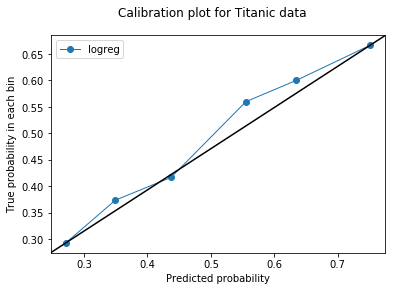

In [29]:
logreg_y, logreg_x = calibration_curve(TwoyearS_Lung2, preds_validation, n_bins=10)
fig, ax = plt.subplots()
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Titanic data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

## 2-year survival classification using Volume only

In [38]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
Train = df1_merge[hugo_volume]
validation =dflung2[hugo_volume]
V_outcome_bs = pd.concat([validation,TwoyearS_Lung2],axis=1)

classifier = LogisticRegression()
classifier.fit(Train,TwoyearS_Lung1)
probs_train = classifier.predict_proba(Train)
preds_train = probs_train[:,1]
fpr_train, tpr_train, threshold_train = metrics.roc_curve(TwoyearS_Lung1, preds_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# ------------------bootstrap 1000 times
n_bs = 1000 
n_sample = validation.shape[0]
n_sample = 100
AUC_Vbs = []
for i in range(n_bs):
    validation_bs = V_outcome_bs.sample(n_sample,replace=True)
    validation_predictor_bs = validation_bs[hugo_volume]
    TwoyearS_lung2bs = validation_bs[hugo_outcome]
    probs_Vbs = classifier.predict_proba(validation_predictor_bs)
    preds_Vbs = probs_Vbs[:,1]
    fpr_Vbs, tpr_Vbs, threshold_Vbs = metrics.roc_curve(TwoyearS_lung2bs, preds_Vbs)
    roc_auc_Vbs = metrics.auc(fpr_Vbs, tpr_Vbs)
    AUC_Vbs.append(roc_auc_Vbs)
AUC_Vbs
print(np.mean(AUC_Vbs))
alpha = 0.95
confidence_interval(AUC_Vbs,alpha)

# --------------------------------------
# probs_validation = classifier.predict_proba(validation)
# preds_validation = probs_validation[:,1]
# fpr_validation, tpr_validation, threshold_validation = metrics.roc_curve(TwoyearS_Lung2, preds_validation)
# roc_auc_validation = metrics.auc(fpr_validation, tpr_validation)

# # method I: plt
# import matplotlib.pyplot as plt
# plt.figure(figsize = (10,8))
# plt.title('ROC of 2-year survival classification by Volume')
# plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
# plt.plot(fpr_validation, tpr_validation, 'r', label = 'Validation AUC = %0.2f' % roc_auc_validation)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'k--')
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# # plt.savefig('./DLR_result/DLR_Volume/DLR_TwoyearS_Volume.pdf')
# plt.show()

0.6324928163588426
95.0 confidence interval 51.6% and 74.0%


### Carlibration Curve

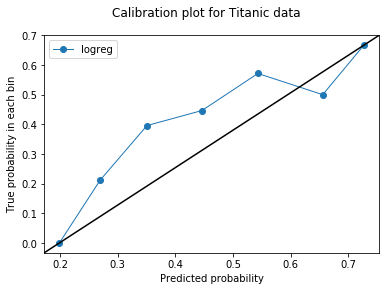

In [34]:
logreg_y, logreg_x = calibration_curve(TwoyearS_Lung2, preds_validation, n_bins=10)
fig, ax = plt.subplots()
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Titanic data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(, y)